## Modules à importer

In [1]:
import math
import scipy
import pickle
import sncosmo
import numpy as np
import pandas as pd
import iminuit as im
import ipywidgets as ipw
from importlib import reload
from scipy.stats import poisson
import scipy.integrate as integrate
from variaIa.variaIa import baserate
from scipy.interpolate import interp1d
from variaIa.variaIa import stretchevol
from astropy.cosmology import Planck15
import matplotlib.pyplot as plt
import random

## Définitions et sélection de l'échantillon à utiliser

In [19]:
d = pd.read_csv('../Data/data_cheat.csv', sep=' ', index_col='CID')
d_snf = pd.read_csv('../Data/lssfr_paper_full_sntable.csv', sep=',')

surveys = ['SNF', 'SDSS', 'PS1', 'SNLS', 'HST']

su = ipw.Dropdown(options=surveys,
                  description='Survey:',
                  value='PS1')

surv = {'SNF':  d_snf,
        'SDSS': d[d['IDSURVEY'] == 1],
        'PS1':  d[d['IDSURVEY'] == 15],
        'SNLS': d[d['IDSURVEY'] == 4],
        'HST':  d[d['IDSURVEY'].isin([101, 100, 106])],
        'survey_all': d[d['IDSURVEY'].isin([1, 15, 4])]}

# .loc[d_snf['name'].str.contains('SNF|LSQ|PTF',na=False,regex=True)]

colors = {'SNF': 'orange',
          'SDSS': 'lime',
          'PS1': 'blue',
          'SNLS': 'red',
          'HST': 'purple'}

def set_data(su):
    global dataz, datax
    if su == 'SNF':
        dataz = np.sort(surv[su]['host.zcmb'].values)
    else:
        dataz = np.sort(surv[su].zCMB.values)
    
int_data = ipw.interactive(set_data, su=su)
display(int_data)

interactive(children=(Dropdown(description='Survey:', index=2, options=('SNF', 'SDSS', 'PS1', 'SNLS', 'HST'), …

# Détermination des $z_{\text{max}}$ _via_ SNcosmo

#### For every (x1, c) in an ([-3, 3], [-0.3, 0.3]) ellipse, we want to find the absolute magnitude 5 days prior to the peak value taken at -19.3: M is indeed a function of (x1, c, t).

#### We set the SN near z=0, with c and x1 to 0 for that is the value that will give the actual peak absolute magnitude, and then we get M by taking the apparent magnitude it has, minus the distance modulus.

In [2]:
M_list = []
model = sncosmo.Model("salt2")
model.set(z=0.00000001, t0=55000, c=0., x1=0)
model.set_source_peakabsmag(-19.3, "bessellb", "ab", cosmo=Planck15)

a=3.     #radius on the x-axis
b=.3    #radius on the y-axis
t = np.linspace(0, 2*np.pi, 1000)

data = dict()

for i in range(len(t)):
    data[i] = {'c': b*np.sin(t)[i],
               'x1': a*np.cos(t)[i]}
    model.update(data[i])
    data[i]['M'] = model.bandmag('bessellb', 'ab', model["t0"]-5)\
                 - Planck15.distmod(model["z"]).value

#### The effective instrinsec magnitude also depends linearly on (x1, c) according to the Tripp equation, and as such we correct for that.

In [3]:
df = pd.DataFrame(data).T
df['M_eff'] = df['M']-0.141*df['x1']+3.15*df['c']

## Plotting the results

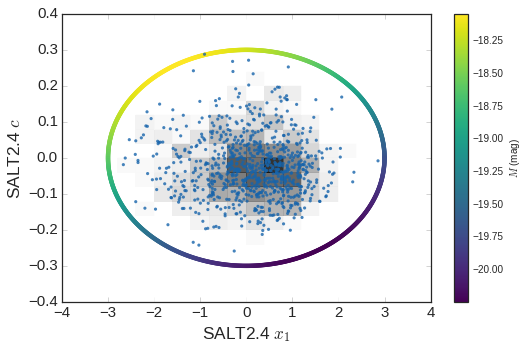

In [56]:
fig = plt.figure(figsize=[8, 5])
ax = fig.add_axes([0.1, 0.12, 0.8, 0.8])

ts = ax.scatter(df['x1'],
                df['c'],
                marker='o',
                cmap='viridis',
                c=df['M_eff'], edgecolors="None",
                s=20,
                zorder=2)

cl = fig.colorbar(ts, label=r'$M$ (mag)')

ax.hist2d(surv['survey_all'].x1,
          surv['survey_all'].c,
          range=[[-4, 4], [-.4, .4]],
          bins=20,
          cmap=plt.cm.binary,
          vmin=1,
          alpha=.8)

ax.scatter(surv['survey_all'].x1,
           surv['survey_all'].c,
           marker='.',
           fc=plt.cm.Blues(.8, .8),
           edgecolors="None",
           lw=.5,
           s=40,
           zorder=2)

ax.tick_params(direction='in',
               length=5, width=1,
               labelsize=15,
               top=True, right=True)

ax.set_xlabel(r'SALT2.4 $x_1$', fontsize='xx-large')
ax.set_ylabel(r'SALT2.4 $c$', fontsize='xx-large')

ax.set_xlim(-4, 4)
ax.set_ylim(-.4, .4)

# plt.legend(ncol=1, loc='upper left', fontsize='x-large')
fig=plt.gcf()
fig.savefig('/home/nora/Documents/Thèse/Images/zmax_maglim_all.pdf')

In [ ]:
df.sort_values('M_eff', ascending=False).iloc[0]['M_eff']

In [ ]:
21.8-df.sort_values('M_eff', ascending=False).iloc[0]['M_eff']

In [ ]:
Planck15.distmod(0.18)

In [ ]:
with open('../Data/zmax_spec_result', 'rb') as f:
    z_lins, meds, stds, z_max, itsc = pickle.load(f)

In [ ]:
z_max

In [ ]:
from scipy import optimize

In [ ]:
def find_zmax(mag_lim, magabs_lim=-18.):
    return(find_z(mag_lim - magabs_lim))

def find_z(distmod, cosmo=None):
    if cosmo is None:
        from astropy.cosmology import Planck15
        cosmo = Planck15
    return(optimize.fmin(lambda z: np.abs(cosmo.distmod(z).value - distmod), 0.1, disp=0))

In [ ]:
find_zmax(24.5)